# 🧪TRANSFER LEARNING VỚI LoRA & ĐÁNH GIÁ MÔ HÌNH 2 GIAI ĐOẠN

---

### 🎯 Mục tiêu
Notebook này triển khai kỹ thuật **Transfer Learning** kết hợp với **LoRA (Low-Rank Adaptation)** để tối ưu hóa mô hình dịch. Đặc biệt, chúng ta sẽ thực hiện đánh giá hiệu năng của mô hình sau khi đã trải qua **2 lần tinh chỉnh (2-stage Fine-tuning)** để kiểm chứng độ hiệu quả trên miền dữ liệu chuyên ngành.

### 🛠️ Quy trình Huấn luyện & Đánh giá
1.  **Giai đoạn 1 (Đã thực hiện):** Mô hình gốc `ViT5-base` đã được fine-tune trên tập dữ liệu tổng quát (General 10k) $\rightarrow$ tạo ra checkpoint `ViT5_base_time1`.
2.  **Giai đoạn 2 (Notebook này):** * Load checkpoint `ViT5_base_time1`.
    * Đóng băng (Freeze) weights gốc và gắn Adapter LoRA.
    * Huấn luyện tiếp trên tập dữ liệu `Augmented Coffee`.
3.  **So sánh & Đánh giá (Crucial Step):** * Sử dụng mô hình đã qua 2 lần huấn luyện để kiểm thử trên tập `TestCoffee.csv`.
    * Mục đích: So sánh xem liệu việc fine-tune 2 giai đoạn (General $\rightarrow$ Domain) có mang lại kết quả vượt trội so với việc chỉ train một lần hay không.

### ⚙️ Công nghệ
* **PEFT (Parameter-Efficient Fine-Tuning):** Giúp train nhanh trên Colab T4.
* **Quantization (8-bit):** Tối ưu hóa bộ nhớ VRAM.

---

In [ ]:
!pip install transformers[torch] accelerate datasets evaluate sacrebleu peft bitsandbytes jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 20.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import torch
import evaluate
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback # <-- Thêm EarlyStopping
)
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt

## Bước 1: Tải và chia dữ liệu

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Corpus-Vie-VSL-11K.csv'

In [ ]:
dataset = Dataset.from_csv(file_path)
train_val_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Tỷ lệ mới: 10% (val) / 90% (train+val) = 0.1112
train_test_split = train_val_dataset['train'].train_test_split(test_size=0.1112, seed=42)

split_dataset = DatasetDict({
    'train': train_test_split['train'],      # ~80%
    'validation': train_test_split['test'],  # ~10% (đổi tên từ 'test')
    'test': train_val_dataset['test']        # ~10%
})
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['vietnamese', 'vsl'],
        num_rows: 9351
    })
    validation: Dataset({
        features: ['vietnamese', 'vsl'],
        num_rows: 1170
    })
    test: Dataset({
        features: ['vietnamese', 'vsl'],
        num_rows: 1170
    })
})


## Bước 2: Tokenizer và tiền xử lý

In [ ]:
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from transformers import T5Config

In [ ]:
model_name = "VietAI/vit5-base"
config = T5Config.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# In tổng số tham số
print(f"Tổng số tham số (parameters) của {model_name}: {model.num_parameters():,}")

# In các thông số kiến trúc chính
print("\n--- Cấu hình chi tiết (config) ---")
print(config)

Tổng số tham số (parameters) của VietAI/vit5-base: 225,950,976

--- Cấu hình chi tiết (config) ---
T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "dtype": "float32",
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.57.1",
  "use_cache": true,
  "vocab_size": 36096
}



In [ ]:
# Tiền tố cho tác vụ dịch (rất quan trọng với T5)
prefix = "dịch tiếng Việt sang VSL: "
max_input_length = 128
max_target_length = 128

In [ ]:
def preprocess_function(examples):
    inputs = [prefix + (doc if doc else "") for doc in examples["vietnamese"]]
    targets = [(doc if doc else "") for doc in examples["vsl"]]

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Áp dụng hàm tiền xử lý cho toàn bộ 3 tập
# VÀ XÓA CÁC CỘT VĂN BẢN GỐC
tokenized_datasets = split_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["vietnamese", "vsl"]  # <-- THÊM DÒNG NÀY
)

Map:   0%|          | 0/9351 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1170 [00:00<?, ? examples/s]

Map:   0%|          | 0/1170 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets["train"][0])

{'input_ids': [951, 787, 506, 1123, 8463, 35859, 35862, 738, 671, 86, 71, 357, 462, 1269, 1612, 110, 992, 162, 233, 54, 846, 1661, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [738, 671, 71, 357, 462, 1269, 1612, 110, 992, 162, 233, 846, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Bước 3: Tải mô hình và cấu hình PERT

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto" # Tự động phân chia lên GPU/CPU
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [ ]:
# Cấu hình LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "v"],  # Chỉ áp dụng LoRA cho lớp Query và Value
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # Cực kỳ quan trọng cho T5
)

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
# In ra số lượng tham số có thể huấn luyện
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 227,720,448 || trainable%: 0.7770


## Bước 4: Định nghĩa hàm đánh giá (BLEU, WER)

In [ ]:
bleu_metric = evaluate.load("sacrebleu")
wer_metric = evaluate.load("wer")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    preds[preds == -100] = tokenizer.pad_token_id

    # Decode dự đoán
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Decode nhãn (thay thế -100 bằng pad_token_id)
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # Xử lý cho BLEU (yêu cầu list of lists cho labels)
    decoded_labels_bleu = [[label] for label in decoded_labels]

    # Tính toán
    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_bleu)
    wer_result = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "bleu": bleu_result["score"],
        "wer": wer_result
    }

## Bước 5: Cấu hình và huấn luyện

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model
)

In [ ]:
# Cấu hình đối số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./vit5-vsl-translator",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs= 10, # Đặt số epochs tối đa (ví dụ: 10),                      Early Stopping sẽ dừng sớm nếu cần
    learning_rate=1e-4,
    weight_decay=0.01,
    predict_with_generate=True, # BẮT BUỘC để sinh text khi đánh giá
    logging_dir="./logs",
    logging_steps=100,

    # Cấu hình quan trọng cho Early Stopping
    eval_strategy="epoch",  # Đánh giá sau mỗi epoch
    save_strategy="epoch",        # Lưu model sau mỗi epoch
    load_best_model_at_end=True,  # Tự động tải model tốt nhất khi kết thúc
    metric_for_best_model="eval_loss",  # Theo dõi chỉ số WER
    greater_is_better=False,     # Vì eval_loss càng thấp càng tốt
    report_to = 'none',
    fp16 = True,
    push_to_hub=False
)

In [ ]:
# Khởi tạo Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], # Dùng tập validation để theo dõi
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/tmp/ipython-input-195320665.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Wer
1,0.032500,0.021430,85.381443,0.101308
2,0.024300,0.015305,89.403203,0.076484
3,0.018800,0.012955,91.709917,0.059935
4,0.015200,0.010153,93.321704,0.048753
5,0.013800,0.009833,93.777770,0.046852
6,0.013000,0.009579,93.177276,0.050095
7,0.011800,0.009102,94.095039,0.043610
8,0.010500,0.008638,94.479384,0.040479
9,0.010000,0.008526,94.654089,0.039808
10,0.009000,0.008575,94.651093,0.039025


TrainOutput(global_step=5850, training_loss=0.017477786337208544, metrics={'train_runtime': 4200.1404, 'train_samples_per_second': 22.264, 'train_steps_per_second': 1.393, 'total_flos': 1.436298892148736e+16, 'train_loss': 0.017477786337208544, 'epoch': 10.0})

In [ ]:
test_results = trainer.evaluate(
    eval_dataset=tokenized_datasets["test"]
)

In [ ]:
print("\nKết quả trên tập Test:")
print(f"  Test BLEU: {test_results['eval_bleu']:.4f}")
print(f"  Test WER:  {test_results['eval_wer']:.4f}")
print(f"  Test Loss: {test_results['eval_loss']:.4f}")


Kết quả trên tập Test:
  Test BLEU: 93.5689
  Test WER:  0.0454
  Test Loss: 0.0089


In [ ]:
# 7. Lưu Model vào Drive
output_model_dir = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer/trained_model"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

Model saved to /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer/trained_model


## Thử nghiệm

In [ ]:
def translate_vi_to_vsl(text, model_to_use, tokenizer_to_use):
    input_text = prefix + text
    inputs = tokenizer_to_use(input_text, return_tensors="pt").to("cuda") # Đảm bảo input lên GPU

    outputs = model_to_use.generate(
        **inputs,
        max_length=128,
        num_beams=5, # Beam search
        early_stopping=True
    )

    return tokenizer_to_use.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Thử nghiệm
test_sentence_1 = "Chào bạn, bạn có khỏe không?"
test_sentence_2 = "Tôi muốn mua một ly cà phê đen không đường."

# Dùng model đã được nạp bởi trainer
print(f"Tiếng Việt: {test_sentence_1}")
print(f"VSL (dịch): {translate_vi_to_vsl(test_sentence_1, trainer.model, tokenizer)}")

print(f"\nTiếng Việt: {test_sentence_2}")
print(f"VSL (dịch): {translate_vi_to_vsl(test_sentence_2, trainer.model, tokenizer)}")

Tiếng Việt: Chào bạn, bạn có khỏe không?
VSL (dịch): Chào bạn bạn có khỏe không?

Tiếng Việt: Tôi muốn mua một ly cà phê đen không đường.
VSL (dịch): Tôi cà-phê đen một đường không muốn


In [ ]:
import pandas as pd

In [ ]:
log_history = trainer.state.log_history
# Chuyển qua DataFrame
df_logs = pd.DataFrame(log_history)

# Tách logs của training và evaluation
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop = True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop = True)

In [ ]:
import matplotlib.pyplot as plt

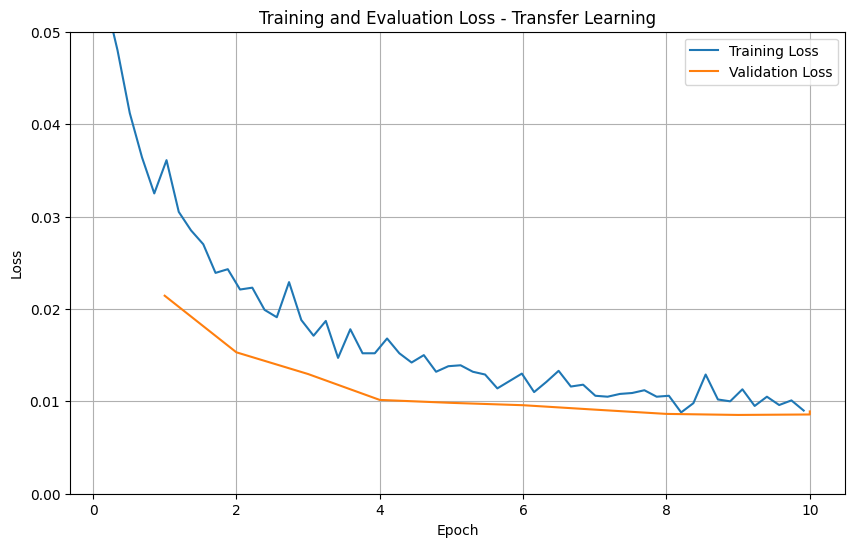

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.title('Training and Evaluation Loss - Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim(0, 0.05)
plt.show()

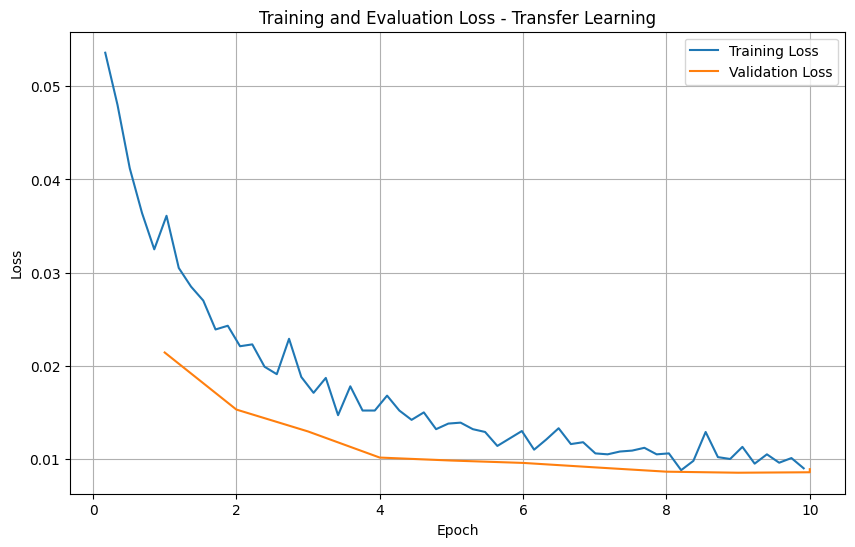

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.title('Training and Evaluation Loss - Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Test trên tập dữ liệu chung

In [ ]:
!pip install transformers[torch] accelerate datasets evaluate sacrebleu peft bitsandbytes jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import torch
import evaluate
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import PeftModel, PeftConfig
import numpy as np

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer_time1/trained_model"
# Đường dẫn file test mới
test_data_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/TestCoffee.csv"

In [ ]:
print(f"Loading model from: {model_path}")
print(f"Loading test data from: {test_data_path}")

Loading model from: /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer_time1/trained_model
Loading test data from: /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/TestCoffee.csv


In [ ]:
# 1. Load Tokenizer từ đường dẫn đã lưu
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# 2. Load Base Model (Vit5-base)
# Vì LoRA chỉ lưu adapter, ta cần load model gốc trước
config = PeftConfig.from_pretrained(model_path)
base_model = T5ForConditionalGeneration.from_pretrained(
    config.base_model_name_or_path,
    device_map="auto",
    load_in_8bit=True # Nếu lúc train bạn dùng 8bit
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [ ]:
# 3. Load LoRA Adapters và ghép vào base model
model = PeftModel.from_pretrained(base_model, model_path)
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
# Load dữ liệu test
test_dataset = Dataset.from_csv(test_data_path)

In [ ]:
# Cấu hình tiền xử lý (Giống hệt lúc train)
prefix = "dịch tiếng Việt sang VSL: "
max_input_length = 128
max_target_length = 128

In [ ]:
def preprocess_function(examples):
    # LƯU Ý: Kiểm tra tên cột trong file TestCoffee.csv
    # Nếu tên cột khác 'vietnamese' và 'vsl', hãy sửa lại ở dưới
    inputs = [prefix + (str(doc).replace('\ufeff', '').strip() if doc else "") for doc in examples["vietnamese"]]
    targets = [(str(doc) if doc else "") for doc in examples["vsl"]]

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# --- ĐOẠN QUAN TRỌNG: THÊM remove_columns ---
# Lấy danh sách tên các cột gốc để xóa đi sau khi tokenize
column_names = test_dataset.column_names

# Tokenize tập test và XÓA các cột cũ
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=column_names  # <--- Dòng này giúp sửa lỗi
)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
# In thử để kiểm tra, lúc này chỉ còn lại input_ids, attention_mask, labels
print("Các cột sau khi xử lý:", tokenized_test.column_names)

Các cột sau khi xử lý: ['input_ids', 'attention_mask', 'labels']


In [ ]:
bleu_metric = evaluate.load("sacrebleu")
wer_metric = evaluate.load("wer")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Xử lý padding trong prediction
    if isinstance(preds, tuple):
        preds = preds[0]

    # Thay thế -100 bằng pad token để decode được
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn bị dữ liệu cho BLEU (cần list of lists cho references)
    decoded_labels_bleu = [[label] for label in decoded_labels]

    # Tính toán
    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_bleu)
    wer_result = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "bleu": bleu_result["score"],
        "wer": wer_result
    }

In [ ]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# Cấu hình tham số đánh giá
training_args = Seq2SeqTrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=16,
    predict_with_generate=True, # Bắt buộc True để tính được BLEU/WER
    fp16=True, # Sử dụng nếu có GPU
    remove_unused_columns=False,
    report_to = 'none'
)

In [ ]:
# Khởi tạo Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2240778306.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("Starting evaluation on TestCoffee dataset...")
metrics = trainer.evaluate(eval_dataset=tokenized_test)

Starting evaluation on TestCoffee dataset...


In [ ]:
print("\n" + "="*30)
print("KẾT QUẢ ĐÁNH GIÁ")
print("="*30)
print(f"Eval Loss: {metrics['eval_loss']:.4f}")
print(f"BLEU:      {metrics['eval_bleu']:.4f}")
print(f"WER:       {metrics['eval_wer']:.4f}")
print("="*30)


KẾT QUẢ ĐÁNH GIÁ
Eval Loss: 0.0234
BLEU:      71.2135
WER:       0.2355


In [ ]:
# 1. In ra 3 mẫu dữ liệu thô từ file CSV mới
print("--- DỮ LIỆU THÔ TỪ CSV ---")
print(test_dataset[:3])

# 2. In ra dữ liệu sau khi giải mã (Decode) từ token
print("\n--- DỮ LIỆU MÔ HÌNH NHÌN THẤY ---")
# Lấy 1 mẫu đã tokenize
sample_input_ids = tokenized_test[0]['input_ids']
sample_label_ids = tokenized_test[0]['labels']

# Decode lại thành chữ
print("Input (Model thấy):", tokenizer.decode(sample_input_ids, skip_special_tokens=True))
print("Label (Nhãn đúng): ", tokenizer.decode(sample_label_ids, skip_special_tokens=True))

--- DỮ LIỆU THÔ TỪ CSV ---
{'vietnamese': ['Tôi 19 tuổi .', 'Bạn tên gì ?', 'Ai biết bơi ?'], 'vsl': ['\ufeffTôi tuổi 19 .', 'Bạn tên gì ?', 'Biết bơi ai ?']}

--- DỮ LIỆU MÔ HÌNH NHÌN THẤY ---
Input (Model thấy): dịch tiếng Việt sang VSL: Tôi 19 tuổi .
Label (Nhãn đúng):  Tôi tuổi 19 .


In [ ]:
# ==========================================
# CODE ĐÃ SỬA LỖI GENERATE
# ==========================================
import torch

print("\n--- SO SÁNH KẾT QUẢ DỊCH (5 CÂU ĐẦU) ---")

# 1. Lấy input_ids và attention_mask từ dữ liệu đã tokenize
input_ids = tokenized_test[:5]['input_ids']
attention_mask = tokenized_test[:5]['attention_mask']

# 2. Chuyển sang Tensor và đưa vào GPU (nếu có)
input_tensor = torch.tensor(input_ids).to(model.device)
mask_tensor = torch.tensor(attention_mask).to(model.device)

# 3. Dự đoán (SỬA LỖI: Dùng keyword argument input_ids=...)
outputs = model.generate(
    input_ids=input_tensor,
    attention_mask=mask_tensor, # Quan trọng: Phải có mask vì đã padding
    max_length=128
)

# 4. Giải mã và in kết quả
decoded_inputs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(tokenized_test[:5]['labels'], skip_special_tokens=True)

for i in range(5):
    print(f"\nCâu {i+1}:")
    print(f"Input:   {decoded_inputs[i]}")
    print(f"Dự đoán: {decoded_preds[i]}")
    print(f"Nhãn:    {decoded_labels[i]}")

    # So sánh chuỗi đã chuẩn hóa khoảng trắng
    if decoded_preds[i].strip() == decoded_labels[i].strip():
        print("=> ĐÁNH GIÁ: CHÍNH XÁC")
    else:
        print("=> ĐÁNH GIÁ: KHÁC BIỆT")


--- SO SÁNH KẾT QUẢ DỊCH (5 CÂU ĐẦU) ---

Câu 1:
Input:   dịch tiếng Việt sang VSL: Tôi 19 tuổi .
Dự đoán: Tôi tuổi 19 .
Nhãn:    Tôi tuổi 19 .
=> ĐÁNH GIÁ: CHÍNH XÁC

Câu 2:
Input:   dịch tiếng Việt sang VSL: Bạn tên gì ?
Dự đoán: Bạn tên gì ?
Nhãn:    Bạn tên gì ?
=> ĐÁNH GIÁ: CHÍNH XÁC

Câu 3:
Input:   dịch tiếng Việt sang VSL: Ai biết bơi ?
Dự đoán: biết bơi ai ?
Nhãn:    Biết bơi ai ?
=> ĐÁNH GIÁ: KHÁC BIỆT

Câu 4:
Input:   dịch tiếng Việt sang VSL: Con gà ăn gì ?
Dự đoán: Con gà ăn gì ?
Nhãn:    Con gà ăn gì ?
=> ĐÁNH GIÁ: CHÍNH XÁC

Câu 5:
Input:   dịch tiếng Việt sang VSL: Mít thì ngọt .
Dự đoán: Mít ngọt .
Nhãn:    Mít ngọt .
=> ĐÁNH GIÁ: CHÍNH XÁC


In [ ]:
# ======================================================
# 1. CÀI ĐẶT VÀ IMPORT
# ======================================================
!pip install transformers[torch] accelerate datasets evaluate sacrebleu peft bitsandbytes jiwer -q

import os
import pandas as pd
import torch
import numpy as np
import evaluate
from google.colab import drive
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import PeftModel, PeftConfig

# Mount Drive (nếu chưa)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# ======================================================
# 2. CẤU HÌNH ĐƯỜNG DẪN
# ======================================================
# Đường dẫn thư mục chứa model
model_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer_time1/trained_model"
# Đường dẫn file test
test_data_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/TestCoffee.csv"

print(f"Model path: {model_path}")
print(f"Data path:  {test_data_path}")

# ======================================================
# 3. LOAD MODEL & TOKENIZER
# ======================================================
print("\nDang load model...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = PeftConfig.from_pretrained(model_path)

# Load base model
base_model = T5ForConditionalGeneration.from_pretrained(
    config.base_model_name_or_path,
    device_map="auto",
    load_in_8bit=True
)
# Load LoRA adapters
model = PeftModel.from_pretrained(base_model, model_path)
print("Load model thành công!")

# ======================================================
# 4. XỬ LÝ DỮ LIỆU (QUAN TRỌNG: LÀM SẠCH & TOKENIZE)
# ======================================================
print("\nĐang xử lý dữ liệu...")

# Hàm làm sạch text (Xóa BOM \ufeff, xóa khoảng trắng thừa)
def clean_text(text):
    text = str(text)
    text = text.replace('\ufeff', '') # Xóa ký tự BOM gây lỗi
    text = text.strip()
    return text

# Đọc CSV bằng Pandas và làm sạch ngay lập tức
df = pd.read_csv(test_data_path)
df['vietnamese'] = df['vietnamese'].apply(clean_text)
df['vsl'] = df['vsl'].apply(clean_text)

# Chuyển sang HuggingFace Dataset
test_dataset = Dataset.from_pandas(df)

# Hàm Tokenize
prefix = "dịch tiếng Việt sang VSL: "
max_len = 128

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["vietnamese"]]
    targets = [doc for doc in examples["vsl"]]

    model_inputs = tokenizer(inputs, max_length=max_len, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_len, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map và XÓA CỘT CŨ (Khắc phục lỗi ValueError tensor)
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

# ======================================================
# 5. ĐỊNH NGHĨA METRIC (BLEU, WER)
# ======================================================
bleu_metric = evaluate.load("sacrebleu")
wer_metric = evaluate.load("wer")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple): preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Thay -100 bằng pad token để decode được
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn bị cho BLEU (list of lists)
    decoded_labels_bleu = [[label] for label in decoded_labels]

    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_bleu)
    wer = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {"bleu": bleu["score"], "wer": wer}

# ======================================================
# 6. CHẠY ĐÁNH GIÁ (EVALUATE)
# ======================================================
print("\nBắt đầu đánh giá...")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./eval_output",
    per_device_eval_batch_size=16,
    predict_with_generate=True, # Bắt buộc True để tính BLEU
    fp16=True,
    remove_unused_columns=False,
    report_to = 'none'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

metrics = trainer.evaluate(eval_dataset=tokenized_test)

print("\n" + "="*40)
print(f" KẾT QUẢ CUỐI CÙNG TRÊN {len(df)} MẪU")
print("="*40)
print(f"Eval Loss: {metrics['eval_loss']:.4f}")
print(f"BLEU:      {metrics['eval_bleu']:.4f}")
print(f"WER:       {metrics['eval_wer']:.4f}")
print("="*40)

# ======================================================
# 7. KIỂM TRA THỰC TẾ (VISUAL CHECK)
# ======================================================
print("\n--- KIỂM TRA 5 CÂU NGẪU NHIÊN ---")
# Lấy 5 mẫu ngẫu nhiên để test
indices = np.random.choice(len(tokenized_test), 5, replace=False)
sample_data = tokenized_test.select(indices)

input_ids = torch.tensor(sample_data['input_ids']).to(model.device)
attention_mask = torch.tensor(sample_data['attention_mask']).to(model.device)

# Generate (Sửa lỗi TypeError bằng cách truyền tham số keyword)
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=128
)

in_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
pred_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
ref_text = tokenizer.batch_decode(sample_data['labels'], skip_special_tokens=True)

for i in range(5):
    print(f"\nMẫu {i+1}:")
    print(f"Input:   {in_text[i]}")
    print(f"Dự đoán: {pred_text[i]}")
    print(f"Đúng:    {ref_text[i]}")

    # So sánh không phân biệt hoa thường để công bằng hơn
    if pred_text[i].strip().lower() == ref_text[i].strip().lower():
        print("=> Đánh giá: TỐT (Khớp nội dung)")
    else:
        print("=> Đánh giá: KHÁC (Cần xem xét)")

Model path: /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/vit5-vsl-translator-transfer_time1/trained_model
Data path:  /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/TestCoffee.csv

Dang load model...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Load model thành công!

Đang xử lý dữ liệu...


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Bắt đầu đánh giá...


/tmp/ipython-input-1465692752.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



 KẾT QUẢ CUỐI CÙNG TRÊN 107 MẪU
Eval Loss: 0.0091
BLEU:      90.4240
WER:       0.0612

--- KIỂM TRA 5 CÂU NGẪU NHIÊN ---

Mẫu 1:
Input:   dịch tiếng Việt sang VSL: Tôi muốn hai ly sữa tươi trân châu đường đen kem trứng.
Dự đoán: Tôi trà sữa hai muốn
Đúng:    Tôi trà sữa hai muốn
=> Đánh giá: TỐT (Khớp nội dung)

Mẫu 2:
Input:   dịch tiếng Việt sang VSL: Tôi học 4 môn .
Dự đoán: Tôi học 4 môn .
Đúng:    Tôi học môn 4 .
=> Đánh giá: KHÁC (Cần xem xét)

Mẫu 3:
Input:   dịch tiếng Việt sang VSL: Mít thì ngọt .
Dự đoán: Mít ngọt .
Đúng:    Mít ngọt .
=> Đánh giá: TỐT (Khớp nội dung)

Mẫu 4:
Input:   dịch tiếng Việt sang VSL: Cho mình xin thêm ít giấy ăn nhé.
Dự đoán: mình giấy ăn ít muốn
Đúng:    mình giấy ăn ít muốn
=> Đánh giá: TỐT (Khớp nội dung)

Mẫu 5:
Input:   dịch tiếng Việt sang VSL: Cho Tôi một ly trà hoa đậu biếc và ba ly nước ép cam.
Dự đoán: Tôi trà hoa đậu biếc một nước ép cam ba muốn
Đúng:    Tôi trà hoa đậu biếc một nước ép cam ba muốn
=> Đánh giá: TỐT (Khớp nội dung)
